# RNN Classification Test
Trying to classify the age of an author based on a written blogpost

## 1. Import libraries

In [ ]:
!pip install torchtext==0.4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load and preprocces the dataframe

In [ ]:
path = '/content/drive/MyDrive/Language, speech and dialogue processing/blogtext_full.xlsx'

In [ ]:
dataset = pd.read_excel(path)
df = pd.DataFrame(dataset)
df = df.drop(['id', 'topic', 'sign', 'date', 'gender'], axis=1)

df = df.sample(300000)
ages = df["age"].unique().tolist()
print(ages)


[24, 25, 15, 16, 34, 23, 33, 17, 26, 14, 27, 13, 39, 40, 41, 47, 42, 37, 35, 44, 38, 46, 36, 48, 43, 45]


In [ ]:
ages.sort()
age_dict = {}
for age in ages:
  age_dict[age] = df.loc[df['age'] == age]

for key, value in age_dict.items():
  age_dict[key] = value
  
print(age_dict)


{13:         age                                               text
5753     13           hello! Good Evening! Just had my dinn...
168188   13                   Ok. That be all engrish happy...
260580   13             The kind folks at JobStarts put on ...
191153   13         i will comment on your blog if you comm...
118362   13         Mood: Pissed Off Music: Disco Duck? Wtf...
...     ...                                                ...
127829   13  Hey There* Well It has been just a DELIGHTFUL ...
172821   13              Cherry I Love U   urlLink            
232380   13         Three Days Grace - [I Hate] Everything ...
117159   13               urlLink    haru&nbsp; urlLink       
126812   13  YesTerDay(22/07/2004).. Is One my most happies...

[5756 rows x 2 columns], 14:         age                                               text
351431   14          Deanna's journal says that they still ...
558972   14             Im in your comic..yahhoo!!!!  nikki...
165431   14     I ju

In [ ]:
# Same range as in pan13 dataset

dataframes_10s = []
dataframes_20s = []
dataframes_30s = []
dataframes_40s = []

for key, value in age_dict.items():
  if 13 <= int(key) <= 17:
    dataframes_10s.append(value)
  elif 23 <= int(key) <= 27:
    dataframes_20s.append(value)
  elif 33 <= int(key) <= 37:
    dataframes_30s.append(value)
  elif 43 <= int(key) <= 47:
    dataframes_40s.append(value)

df_10s = pd.concat(dataframes_10s)
df_20s = pd.concat(dataframes_20s)
df_30s = pd.concat(dataframes_30s)
df_40s = pd.concat(dataframes_40s)

all_dataframes = [df_10s, df_20s, df_30s, df_40s]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)

df_10s["age"] = 0
df_20s["age"] = 1
df_30s["age"] = 2
df_40s['age'] = 3

all_dataframes = [df_10s.sample(min_len), df_20s.sample(min_len), df_30s.sample(min_len), df_40s.sample(min_len)]


df = pd.concat(all_dataframes)



In [ ]:
df

,age,text
137683,0,haiyo~.Today weather very bad sia. Early morni...
490884,0,"*whimpers* Sorry, Laura, got pulled off the in..."
169978,0,the time we spend together its the happ...
168156,0,i was absolutely unable to comprehe...
554569,0,Poe's cool :p What did you h...
...,...,...
351883,3,"urlLink Meet Greg Schindel, a great guy..."
107783,3,A Stray Thought By Henrietta Asher Handy Co...
216026,3,We will be discussing sparcworks for the Sun B...
115127,3,Last night I tried to get on and tell m...


## 3. Create n_grams from the text (Optional)

In [ ]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    wrong_words = ["urllink", "nbsp"]
    tokens = [token for token in text.split(" ") if token != "" and token not in wrong_words]
    return tokens

def lowered(s):
    return s.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [ ]:
df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)
print(df['text'].iloc[0])
print(df['text'])

['haiyo', 'today', 'weather', 'very', 'bad', 'sia', 'early', 'morning', 'rain', 'make', 'me', 'so', 'sian', 'today', 'go', 'school', 'kinda', 'special', 'because', 'this', 'is', 'the', 'first', 'time', 'i', 'took', 'bus', 'to', 'school', 'for', 'this', 'year', 'thing', 'was', 'kinda', 'different', 'now', 'a', 'days', 'in', 'the', 'bus', 'interchange', 'there', 'was', 'a', 'very', 'long', 'que', 'in', 'one', 'of', 'the', 'berth', 'never', 'seen', 'that', 'before', 'it', 'was', 'very', 'long', 'other', 'different', 'thing', 'is', 'that', 'our', 'school', 'student', 'does', 'not', 'wait', 'at', 'the', 'bus', 'stop', 'anymore', 'they', 'tend', 'to', 'wait', 'at', 'one', 'corner', 'of', 'the', 'interchange', 'when', 'the', 'bus', 'come', 'they', 'kinda', 'cut', 'que', 'maybe', 'for', 'today', 'i', 'saw', 'this', 'situation', 'bah', 'special', 'case', 'ahahaha', 'saw', 'benjamin', 'and', 'wei', 'tian', 'on', 'the', 'bus', 'the', 'bus', 'was', 'so', 'crowded', 'with', 'people', 'hardly', 'any

In [ ]:
df.index = range(len(df))


Pre processing data loader

In [ ]:
class_choice = 'age'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

[0, 1, 2, 3]
classdict:
{0: 6856, 1: 6856, 2: 6856, 3: 6856}


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [ ]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

{'the': 254817, 'i': 215482, 'to': 175678, 'and': 160680, 'a': 131459, 'of': 115200, 'it': 83667, 'in': 83553, 'that': 82655, 'is': 64243, 'you': 58871, 'my': 56972, 'for': 55153, 's': 54184, 'was': 49705, 'on': 44710, 't': 40052, 'with': 38730, 'this': 38336, 'have': 38279, 'but': 37303, 'me': 37176, 'so': 34776, 'we': 34545, 'be': 33931, 'he': 32818, 'not': 30544, 'at': 30296, 'as': 29571, 'all': 26507, 'are': 26167, 'they': 24653, 'just': 21731, 'like': 21553, 'out': 21523, 'up': 21356, 'what': 21260, 'about': 20932, 'she': 20903, 'or': 20607, 'from': 20590, 'm': 20544, 'one': 20380, 'can': 20180, 'her': 19532, 'if': 19317, 'there': 18531, 'do': 18386, 'had': 18246, 'will': 17945, 'when': 17303, 'his': 17202, 'by': 16715, 'get': 16451, 'time': 15426, 'an': 14968, 'no': 14655, 'some': 14422, 'now': 14300, 'know': 14257, 'who': 14210, 'more': 13838, 'would': 13671, 'your': 13636, 'has': 13292, 'then': 13281, 'don': 13146, 'people': 12279, 'am': 12269, 'been': 12230, 'him': 12044, 'go'

In [ ]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

{'the': 0, 'i': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'it': 6, 'in': 7, 'that': 8, 'is': 9, 'you': 10, 'my': 11, 'for': 12, 's': 13, 'was': 14, 'on': 15, 't': 16, 'with': 17, 'this': 18, 'have': 19, 'but': 20, 'me': 21, 'so': 22, 'we': 23, 'be': 24, 'he': 25, 'not': 26, 'at': 27, 'as': 28, 'all': 29, 'are': 30, 'they': 31, 'just': 32, 'like': 33, 'out': 34, 'up': 35, 'what': 36, 'about': 37, 'she': 38, 'or': 39, 'from': 40, 'm': 41, 'one': 42, 'can': 43, 'her': 44, 'if': 45, 'there': 46, 'do': 47, 'had': 48, 'will': 49, 'when': 50, 'his': 51, 'by': 52, 'get': 53, 'time': 54, 'an': 55, 'no': 56, 'some': 57, 'now': 58, 'know': 59, 'who': 60, 'more': 61, 'would': 62, 'your': 63, 'has': 64, 'then': 65, 'don': 66, 'people': 67, 'am': 68, 'been': 69, 'him': 70, 'go': 71, 'really': 72, 'were': 73, 'them': 74, 'how': 75, 'think': 76, 'well': 77, 'good': 78, 'our': 79, 'their': 80, 'back': 81, 'day': 82, 'going': 83, 'got': 84, 'because': 85, 'see': 86, 'love': 87, 'which': 88, 'here': 89, 'on

## 8. Mapping text column to numbers (tensor)

In [ ]:
import numpy as np
text_int_list = []
text_lengths = []
for i, text in enumerate(df['text']):
  newtext = []
  lens = []
  for word in text:
    newtext.append(int(wordmap[word]))
  text_lengths.append(len(newtext))
  text_int_list.append(newtext)
average_len = int(sum(text_lengths) / len(text_lengths))
df["lengths"] = text_lengths

encoding_padded = []
for ints in text_int_list:
  N = average_len
  zeros = np.zeros(N, dtype=int)
  encoded = zeros
  length = min(N, len(ints))
  encoded[:length] = ints[:length]
  encoding_padded.append(np.array((encoded, len(ints))))

df["encoded"] = encoding_padded
df



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,age,text,lengths,encoded
0,0,"[haiyo, today, weather, very, bad, sia, early,...",342,"[[19807, 101, 919, 111, 192, 4000, 453, 222, 9..."
1,0,"[whimpers, sorry, laura, got, pulled, off, the...",178,"[[59709, 450, 2699, 84, 1311, 112, 0, 648, 149..."
2,0,"[the, time, we, spend, together, its, the, hap...",83,"[[0, 54, 23, 614, 335, 132, 0, 9083, 1, 93, 16..."
3,0,"[i, was, absolutely, unable, to, comprehend, t...",9,"[[1, 14, 1161, 2604, 2, 7531, 0, 1264, 101, 0,..."
4,0,"[poe, s, cool, p, what, did, you, have, to, do...",12,"[[10041, 13, 323, 460, 36, 110, 10, 19, 2, 47,..."
...,...,...,...,...
27419,3,"[meet, greg, schindel, a, great, guy, he, s, t...",42,"[[615, 1315, 113870, 4, 152, 255, 25, 13, 0, 1..."
27420,3,"[a, stray, thought, by, henrietta, asher, hand...",66,"[[4, 8379, 163, 52, 36764, 19355, 5021, 2729, ..."
27421,3,"[we, will, be, discussing, sparcworks, for, th...",27,"[[23, 49, 24, 3328, 113871, 12, 0, 707, 7188, ..."
27422,3,"[last, night, i, tried, to, get, on, and, tell...",682,"[[108, 131, 1, 485, 2, 53, 15, 3, 194, 11, 366..."


In [ ]:
X = list(df['encoded'])
y = list(df['age'])
print(X[0])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

[array([19807,   101,   919,   111,   192,  4000,   453,   222,   961,
         115,    21,    22,  6516,   101,    71,   177,   595,   626,
          85,    18,     9,     0,   117,    54,     1,   251,   957,
           2,   177,    12,    18,   154,   137,    14,   595,   320,
          58,     4,   179,     7,     0,   957, 16954,    46,    14,
           4,   111,   150,  1601,     7,    42,     5,     0, 24177,
         128,   348,     8,   138,     6,    14,   111,   150,    92,
         320,   137,     9,     8,    79,   177,  1216,   206,    26,
         384,    27,     0,   957,   325,   650,    31,  1538,     2,
         384,    27,    42,  1510,     5,     0, 16954,    50,     0,
         957,   156,    31,   595,   677,  1601,   185,    12,   101,
           1,   287,    18,   791,  4863,   626,   491, 20974,   287,
        9433,     3,  8580, 13896,    15,     0,   957,     0,   957,
          14,    22,  5012,    17,    67,  1815,   130,   212,  2065,
          50,    23

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BlogDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = BlogDataset(X_train, y_train)
valid_ds = BlogDataset(X_valid, y_valid)

**TO-DO:**

*   Confusion matrix
*   Activation words





In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/Blog_rnn_confusion_matrix.png')
    

In [ ]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            l = l.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            x, y, l = x.to(device), y.to(device), l.to(device)
            loss = F.cross_entropy(y_pred, y).to(device)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        train_loss = sum_loss/total
        print('Epoch: %d' %(i + 1))
        print(f'\tLoss: {train_loss:.4f}(train)\t')
        print(f'\tLoss: {val_loss:.4f}(valid)\t|\tAcc: {val_acc * 100:.1f}%(valid) | \tRMSE: {val_rmse * 100:.1f}(valid)')
        if i == (epochs-1):
          predictions, labels = validation_metrics(model, val_dl, True)
          conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1, 2, 3])
          np.set_printoptions(precision=2)
          # Plot non-normalized confusion matrix
          #plt.figure()
          plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s', '40s'], normalize=True, title='Blog RNN Confusion matrix, with normalization')



def validation_metrics (model, valid_dl, last_epoch=False):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    predictions = []
    labels = []
    for x, y, l in valid_dl:
        x,y,l = x.to(device), y.to(device), l.to(device)
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(1)
        predict = pred.to('cpu')
        label = y.to('cpu')
        predictions.extend(predict)
        labels.extend(label)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), y.unsqueeze(-1).cpu()))*y.shape[0]
    if last_epoch == False:
      return sum_loss/total, correct/total, sum_rmse/total
    else:
      return predictions, labels



In [ ]:
batch_size = 256
vocab_size = len(vocabdict)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
print(f"Vocab size: {vocab_size}")

# Rule of thumb voor embed dim volgens: 
# (https://datascience.stackexchange.com/questions/31109/ratio-between-embedded-vector-dimensions-and-vocabulary-size)

embedding_dimensions =  int(vocab_size**0.25)

model_fixed =  LSTM_fixed_len(vocab_size, embedding_dimensions, 50).to(device)

Vocab size: 113881


Epoch: 1
	Loss: 1.4012(train)	
	Loss: 1.3901(valid)	|	Acc: 25.5%(valid) | 	RMSE: 184.3(valid)
Epoch: 2
	Loss: 1.3863(train)	
	Loss: 1.3906(valid)	|	Acc: 26.3%(valid) | 	RMSE: 135.7(valid)
Epoch: 3
	Loss: 1.3735(train)	
	Loss: 1.3900(valid)	|	Acc: 27.2%(valid) | 	RMSE: 176.7(valid)
Epoch: 4
	Loss: 1.3451(train)	
	Loss: 1.3477(valid)	|	Acc: 33.3%(valid) | 	RMSE: 136.9(valid)
Epoch: 5
	Loss: 1.2512(train)	
	Loss: 1.3003(valid)	|	Acc: 37.4%(valid) | 	RMSE: 136.2(valid)
Epoch: 6
	Loss: 1.1269(train)	
	Loss: 1.2882(valid)	|	Acc: 39.5%(valid) | 	RMSE: 124.4(valid)
Epoch: 7
	Loss: 1.0394(train)	
	Loss: 1.3226(valid)	|	Acc: 41.1%(valid) | 	RMSE: 111.2(valid)
Epoch: 8
	Loss: 0.9598(train)	
	Loss: 1.3503(valid)	|	Acc: 41.5%(valid) | 	RMSE: 112.9(valid)
Epoch: 9
	Loss: 0.8907(train)	
	Loss: 1.3623(valid)	|	Acc: 41.2%(valid) | 	RMSE: 109.5(valid)
Epoch: 10
	Loss: 0.8224(train)	
	Loss: 1.4031(valid)	|	Acc: 40.5%(valid) | 	RMSE: 111.9(valid)
Epoch: 11
	Loss: 0.7520(train)	
	Loss: 1.4745(valid)	|	Acc:

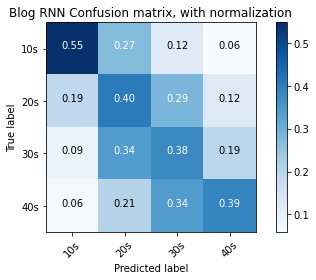

In [ ]:

train_model(model_fixed, epochs=50, lr=0.01)

In [ ]:
pred = [0,2,1,0,2,1]
labels = [0,1,1,2,1,1]

conf_matrix = confusion_matrix(np.array(labels), np.array(pred), labels=[0, 1, 2])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s'], title='Confusion matrix')

